# Detección de Idiomas - Transformer

### Importar librerías

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from datasets import Dataset, DatasetDict, ClassLabel, load_dataset
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

### Cargar el dataset

In [49]:
df = pd.read_csv("dataset/updated_language_detection.csv")
language_names = df['Language'].unique().tolist()
#dataset = load_dataset("csv", data_files="dataset/updated_language_detection.csv")
dataset = Dataset.from_pandas(df)
class_label = ClassLabel(names=language_names)
dataset = dataset.cast_column("Language", class_label)
print(dataset)
print(dataset.features)

/home/bauti/Documents/Facultad/4°/ia2-language-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparación de los Datos

Se dividen los datos en tres conjuntos, con la siguiente proporción:

Train: 70%

Validation: 10%

Test: 20%

In [50]:
train_test_valid = dataset.train_test_split(test_size=0.2, stratify_by_column='Language')
train_valid = train_test_valid['train'].train_test_split(test_size=0.125, stratify_by_column='Language')
datasets = DatasetDict({
    'train': train_valid['train'],
    'validation': train_valid['test'],
    'test': train_test_valid['test']
})

# Tokenizar datos
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Map: 100%|██████████| 4365/4365 [00:02<00:00, 1703.75 examples/s]


In [51]:
# Preparar las entradas y etiquetas para TensorFlow
def prepare_tf_dataset(dataset, label_col="Language", batch_size=8):
    # Convertir etiquetas a one-hot encoding
    num_classes = len(language_names)
    labels = to_categorical(dataset[label_col], num_classes=num_classes)

    # Crear dataset de TensorFlow
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": dataset["input_ids"],
            "attention_mask": dataset["attention_mask"]
        },
        labels
    )).batch(batch_size)

train_dataset = prepare_tf_dataset(tokenized_datasets["train"])
val_dataset = prepare_tf_dataset(tokenized_datasets["validation"])
test_dataset = prepare_tf_dataset(tokenized_datasets["test"])

In [52]:
# Cargar el modelo
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=len(language_names))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [53]:
# Compilar el modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [54]:
# Entrenar el modelo
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
 952/1910 [=============>................] - ETA: 10:51:46 - loss: 8.0348 - accuracy: 0.0473

KeyboardInterrupt: 

In [ ]:
# Evaluar el modelo
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

### Guardar el modelo

In [15]:
model.save("models/transformer_model_1.keras")

/home/bauti/Documents/Facultad/4°/ia2-language-detection/.venv/lib/python3.12/site-packages/tf_keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
/home/bauti/Documents/Facultad/4°/ia2-language-detection/.venv/lib/python3.12/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


#### Matriz de Confusión

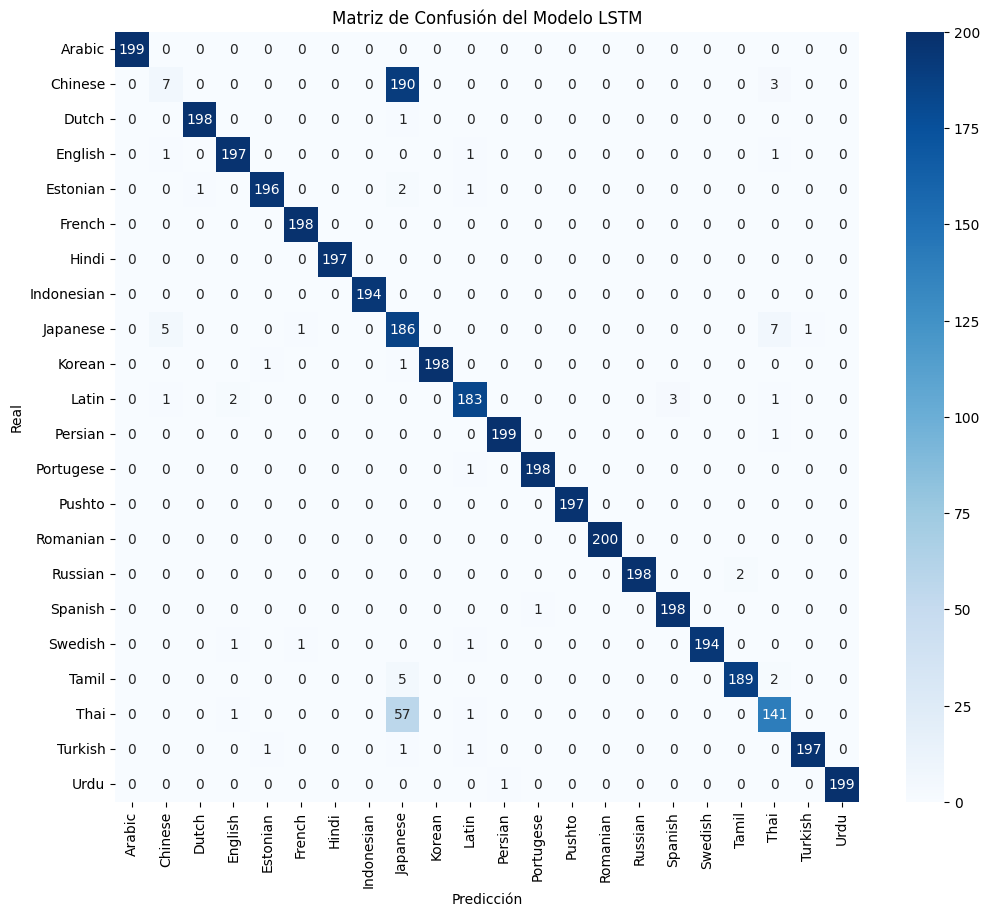

<Figure size 640x480 with 0 Axes>

In [41]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
plt.savefig("plots/lstm_confusion_matrix.png")

### Accuracy en Train y Test

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### Loss en Train y Test

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()